In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from prophet import Prophet

/Users/seubsons/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv("history_map_temp2m_rate_to_2023-11-03T06_00_00.csv")

In [3]:
df.date = pd.to_datetime(df.date)
df.set_index("date",drop=True, inplace=True)

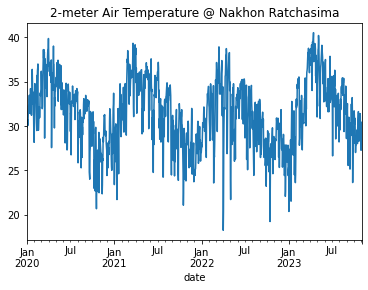

In [4]:
df['max'].plot(title='2-meter Air Temperature @ Nakhon Ratchasima')
plt.show()

In [5]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

/Users/seubsons/miniconda3/envs/myenv/lib/python3.8/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [6]:
training_data = ListDataset(
    [{"start": df.index[0], "target": df['max'][: "2023-01-01T00:00:00.000000"]}],
    freq="D"
)

In [7]:
entry = next(iter(training_data))
train_series = to_pandas(entry)

In [8]:
training_df = pd.DataFrame({'ds': train_series.index, 'y': train_series.values})

In [9]:
training_df['ds'] = training_df['ds'].dt.to_timestamp()

In [10]:
# Test data
test_data = ListDataset(
    [{"start": df.index[0], "target": df['max'][:"2023-11-03T00:00:00.000000"]}],
    freq = "D"
)

In [11]:
entry = next(iter(test_data))
test_series = to_pandas(entry)

In [12]:
index_train_end = df.index.get_loc('2023-01-01')

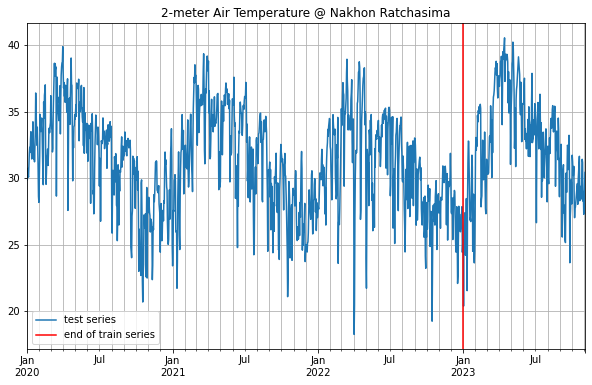

In [13]:
plt.figure(figsize=(10, 6))
test_series.plot(title='2-meter Air Temperature @ Nakhon Ratchasima')

plt.axvline(df.index[index_train_end], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="lower left")
plt.show()

## Select the Model

In [14]:
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

In [15]:
# callbacks = [
#     LearningRateReduction(objective="min",
#                           patience=10,
#                           base_lr=1e-3,
#                           decay_factor=0.5,
#                           ),
#     ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
# ]


estimator = DeepAREstimator(
    freq="M",
    prediction_length=306,
    context_length=306,
    num_layers = 2,
    num_cells = 40,
    distr_output=StudentTOutput(),
    dropout_rate=0.01,
    trainer=Trainer(epochs=30))
    # trainer=Trainer(#ctx = mx.context.gpu(),
    #                 epochs=5,
    #                 callbacks=callbacks))


In [16]:
%%time
predictor = estimator.train(training_data)

100%|██████████| 50/50 [00:11<00:00,  4.46it/s, epoch=30/30, avg_epoch_loss=1.95]

CPU times: user 7min 33s, sys: 8.48 s, total: 7min 42s
Wall time: 5min 40s


In [17]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [18]:
forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

In [19]:
from matplotlib.dates import date2num

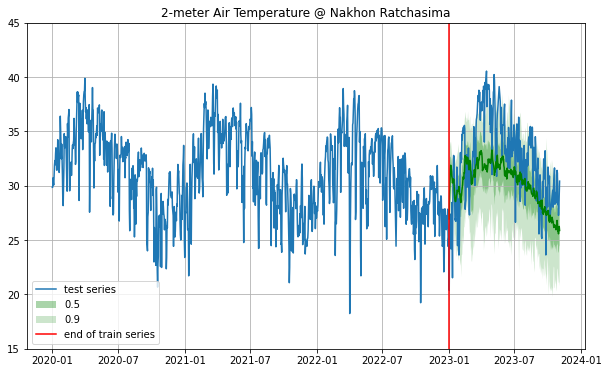

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(ts_entry.to_timestamp(),label="test series")
forecast_entry.plot(show_label=True, color='g')
plt.grid(which="both")
plt.axvline(df.index[index_train_end], color='r', label="end of train series") # end of train dataset
plt.legend(loc="lower left")
plt.title('2-meter Air Temperature @ Nakhon Ratchasima')

# Set the date range and format the x-axis
# date_start = pd.to_datetime('2022-01-01')
# date_end = pd.to_datetime('2024-01-01')
# plt.xlim(date2num(date_start), date2num(date_end))
# plt.xticks(pd.date_range(start='2022-01-01', end='2024-01-01', freq='6M').strftime('%Y-%m'))
# plt.xlabel('Date')
plt.ylim(15,45)

# outfile_png = 'deepar_model_L5'
# outfile_png = 'deepar_model_L02_C40_D'
# plt.savefig(outfile_png, dpi=200, bbox_inches='tight')

plt.show()